# Fourth homework

## Maximum Likelihood Estimation (MLE)

The first part of the fourth homework is about optimizing the MLE-related loss function:
$$\theta_{MLE} = \argmax_{\theta \in \mathbb{R^K}} p_{\theta}(y|x)= \argmin_{\theta \in \mathbb{R^K}}\frac{1}{2}\|\Phi(X)^T\theta - Y\|^2_2$$
where $\Phi$ is the feature matrix and $Y$ is the target vector
$$
\Phi(X) = \begin{bmatrix} 1 & 1 & \dots & 1 \\ x^1 & x^2 & \dots & x^N \\ (x^1)^2 & (x^2)^2 & \dots & (x^N)^2 \\ \vdots & \vdots & \dots & \vdots \\ (x^1)^{K-1} & (x^2)^{K-1} & \dots & (x^N)^{K-1} \end{bmatrix} \in \mathbb{R^{K \times N}}, \qquad Y = \begin{bmatrix} y^1 & y^2 & \dots & y^N \end{bmatrix} \in \mathbb{R^N}.
$$

I begin by loading the data used for the train set, from `poly_regression_small.csv`, and a $20\%$ data sample from the `poly_regression_large.csv` as the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('poly_regression_small.csv')
train = np.array(df)
Xtrain = train[:,1]
Xtrain = Xtrain.reshape((1,Xtrain.shape[0]))
Ytrain = train[:,2]

df = pd.read_csv('poly_regression_large.csv')
large = np.array(df)
Xlarge = large[:,1]
Xlarge = Xlarge.reshape((1,Xlarge.shape[0]))
Ylarge = large[:,2]

def split_data(X, Y, Ntrain):
    N = X.shape[1]
    idx = np.arange(N)
    np.random.shuffle(idx)
    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]
    tr = X[:, train_idx]
    tr = Y[train_idx]
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]
    return (tr, tr), (Xtest, Ytest)

(trX, trY), (Xtest, Ytest) = split_data(Xlarge, Ylarge, int((8/10)*Xlarge.shape[1]))

def generate_matrix(x, K):
    Phi = np.zeros((K, x.shape[1]))
    for i in range(K):
        Phi[i,:] = x ** i
    return Phi

def model(x, theta):
    val = 0
    for i in range(len(theta)):
        val += x ** i * theta[i]
    return val

The following code implements the Gradient Descent and the Stochastic Gradient Descent methods that I will need later on to solve the previously defined optimization problem.

In [2]:
def SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs, K):
    X, y = D 
    N = X.shape[1]
    d = theta0.shape[0]
    idx = np.arange(0, N) 
    
    theta_history = np.zeros((n_epochs, d)) 
    loss_history = np.zeros((n_epochs, )) 
    grad_norm_history = np.zeros((n_epochs, )) 
    
    theta = theta0
    for epoch in range(n_epochs):
        np.random.shuffle(idx)
        X = X[:,idx]
        y = y[idx]

        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[:,batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            Phi = generate_matrix(X_batch, K)
            gradient = grad_loss(theta, Phi, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            theta = theta - alpha * gradient

        theta_history[epoch] = theta
        Phi = generate_matrix(X, K)
        loss_history[epoch] = loss(theta, Phi, y)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

In [3]:
def backtracking(f, grad_f, theta, Phi, y):
    alpha = 1
    c = 0.8
    tau = 0.25  
 
    grad = grad_f(theta, Phi, y)  
    grad_norm_squared = np.linalg.norm(grad, 2) ** 2 
    while f(theta - alpha * grad_f(theta, Phi, y), Phi, y) > f(theta, Phi, y) - c * alpha * grad_norm_squared:
        alpha = tau * alpha
    return alpha

def GD_backtracking(loss, grad_loss, D, theta0, K,  maxit=500, tolf=1e-6, tolx=1e-6):
    Xtrain, y = D  
    
    loss_history = np.zeros((maxit, ))
    grad_norm_history = np.zeros((maxit,))
    theta_history = []

    Phi = generate_matrix(Xtrain, K)

    theta_history.append(theta0)
    loss_history[0] = loss(theta0, Phi, y)
    grad_norm_history[0] = np.linalg.norm(grad_loss(theta0, Phi, y), 2)

    for k in range (1, maxit):
        alpha = backtracking(loss, grad_loss, theta0, Phi, y)
        theta = theta0 - alpha * grad_loss(theta0, Phi, y)
        theta_history.append(theta)

        loss_history[k]= loss(theta, Phi, y)
        grad_norm_history[k] = np.linalg.norm(grad_loss(theta, Phi, y), 2)

        if np.linalg.norm(grad_loss(theta, Phi, y), 2) < tolf * grad_norm_history[0] or np.linalg.norm(theta - theta0, 2) < tolx:
            break 

        theta0 = theta
        
    loss_history = loss_history[:k+1]
    grad_norm_history = grad_norm_history[:k+1]

    return theta_history, k, loss_history, grad_norm_history

I am asked to find the $\theta_{MLE}$ as defined at the beginning of the homework with Gradient Descent, Stochastic Gradient Descent and the by solving the Normal Equations. The following code defines the objective function, it's gradient and the three training procedures.

In [4]:
def mle_Obj(theta, Phi, y):
    return np.linalg.norm((Phi.T@theta - y), 2)**2 / 2

def mle_grad(theta, Phi, y):
    return ((Phi@Phi.T@theta) - (Phi@y))

def mle_Normal_Eq(X, Y, K):
    Phi = generate_matrix(X,K)
    L = np.linalg.cholesky(Phi@Phi.T)
    z = np.linalg.solve(L,Phi@Y)
    theta = np.linalg.solve(L.T, z)
    return theta

def mle_SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs, K):
    thetas, losses, grad_norms = SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs, K)
    return thetas[-1]

def mle_GD_backtracking(loss, grad_loss, D, theta0, K, maxit=1000):
    thetas, k, f_val, grad_norm = GD_backtracking(loss, grad_loss, D, theta0, K, maxit)
    return thetas[-1]

The code below implements the testing procedure that plots the three learned regression models, as well as the train and test data. The code also prints the performance score of each obtained model. The performance of the models are measured the with the folowing metric:
$$Err = \frac{1}{N_{test}}\sum_{i=1}^{N_{\text{test}}} \left(f_{\theta}(x^i) - y^i\right)^2.$$

The error made by the polynomial model trained with SGD method is: 0.0286.
The error made by the polynomial model trained with GD method is: 0.0146.
The error made by the polynomial model trained with Normal equations method is: 0.0114.


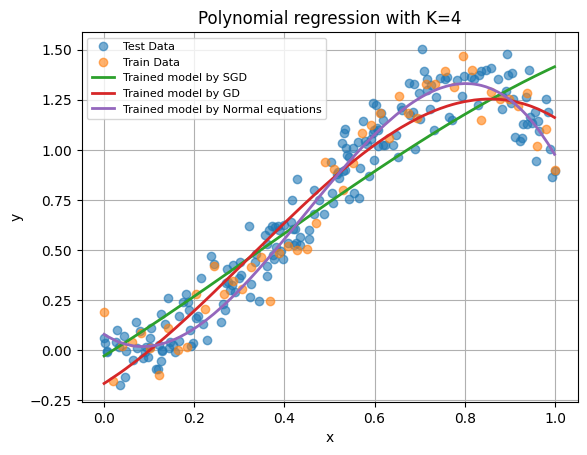

In [5]:
methods = ['SGD', 'GD', 'Normal equations']

def plot_compare(Dtest, Dtrain,thetas,K):

    plt.title(f"Polynomial regression with K={K}")
    plt.plot(Dtest[0], Dtest[1], 'o', label='Test Data', alpha=0.6)
    plt.plot(Dtrain[0], Dtrain[1], 'o', label='Train Data', alpha=0.6)
    for i in range(len(thetas)):
        plt.plot(Dtest[0], model(Dtest[0],thetas[i]), linewidth=2, label=f'Trained model by {methods[i]}')
    plt.legend(fontsize=8)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()

def test_reg_models(loss, grad_loss, Dtrain, Dtest, K, theta0, alpha, size_batch, n_epochs):
    perf = []

    theta_SGD = mle_SGD(loss, grad_loss, Dtrain, theta0, alpha, size_batch, n_epochs, K)
    theta_GD = mle_GD_backtracking(loss, grad_loss, Dtrain, theta0, K)
    theta_NE = mle_Normal_Eq(Dtrain[0], Dtrain[1], K)

    for theta in [theta_SGD, theta_GD, theta_NE]:
        predictions = model(Dtest[0], theta)
        errors = (predictions - Dtest[1]) ** 2
        mean_error = np.mean(errors)
        perf.append(mean_error)

    Xtest = Dtest[0]
    Ytest = Dtest[1]
    Xtest = Xtest.flatten()
    sorted_indices = np.argsort(Xtest) 
    Xtest_sorted = Xtest[sorted_indices]
    Ytest_sorted = Ytest[sorted_indices]
    Xtrain = Dtrain[0]
    Ytrain = Dtrain[1]
    Xtrain = Xtrain.flatten()
    sorted_indices = np.argsort(Xtrain) 
    Xtrain_sorted = Xtrain[sorted_indices]
    Ytrain_sorted = Ytrain[sorted_indices]

    plot_compare((Xtest_sorted, Ytest_sorted), (Xtrain_sorted, Ytrain_sorted), [theta_SGD, theta_GD, theta_NE], K)
    return perf, (theta_SGD, theta_GD, theta_NE)


errors, thetas = test_reg_models(mle_Obj, mle_grad, (Xtrain,Ytrain), (Xtest, Ytest), 4, np.zeros((4,)), 0.01, 5, 200)
for i in range(len(methods)):
    print(f"The error made by the polynomial model trained with {methods[i]} method is: {round(errors[i], 4)}.")
plt.show()

As visible from the output of the code the method that uses Normal Equations is the best performing out of all three of them, for $K=4$.

Below I visualize the same plot as before, but for increasing values of K. 

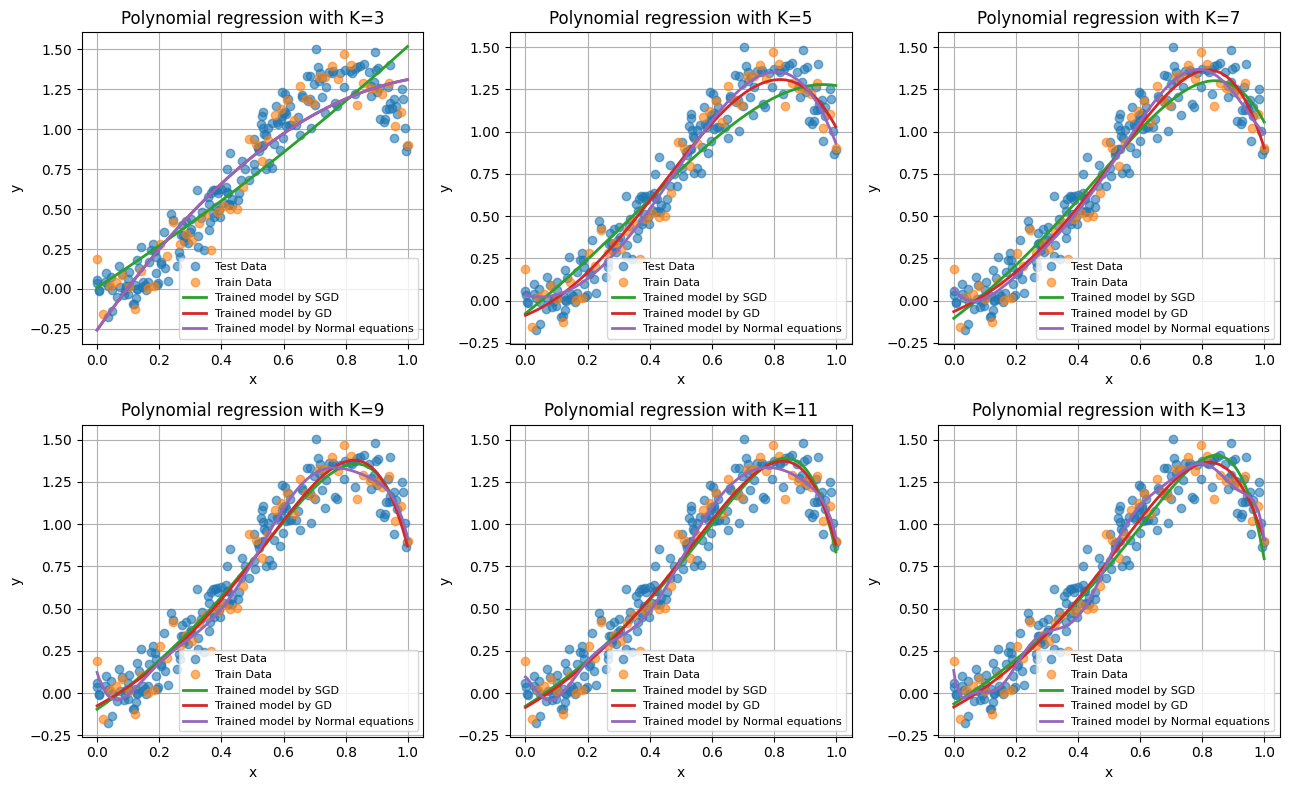

In [6]:
plt.figure(figsize=(13,8))
plt.subplot(2,3,1)
test_reg_models(mle_Obj, mle_grad, (Xtrain,Ytrain), (Xtest, Ytest), 3, np.zeros((3,)), 0.01, 5, 200)
plt.subplot(2,3,2)
test_reg_models(mle_Obj, mle_grad, (Xtrain,Ytrain), (Xtest, Ytest), 5, np.zeros((5,)), 0.01, 5, 200)
plt.subplot(2,3,3)
test_reg_models(mle_Obj, mle_grad, (Xtrain,Ytrain), (Xtest, Ytest), 7, np.zeros((7,)), 0.01, 5, 200)
plt.subplot(2,3,4)
test_reg_models(mle_Obj, mle_grad, (Xtrain,Ytrain), (Xtest, Ytest), 9, np.zeros((9,)), 0.01, 5, 200)
plt.subplot(2,3,5)
test_reg_models(mle_Obj, mle_grad, (Xtrain,Ytrain), (Xtest, Ytest), 11, np.zeros((11,)), 0.01, 5, 200)
plt.subplot(2,3,6)
test_reg_models(mle_Obj, mle_grad, (Xtrain,Ytrain), (Xtest, Ytest), 13, np.zeros((13,)), 0.01, 5, 200)
plt.tight_layout()

It is evident how the model trained with the Normal Equation method is subject to overfitting. When increasing the degree of the model $K$ the curve that represents the trained model becomes less and less representative of data distribution, with many sudden changes of slope, that are not a property of the considered dataset. The trained model with higher values for $K$ becomes more representative of train data, modeling also the noise in the data, as can be seen from the fact that the curve closely follows their pattern loosing the $x$-$y$ relation.

From the plots both the models trained with GD and SGD don't seem to overfit the train data and their noise.

**Train and test error plot**

The idea of overfitting can be analyzed in a better way by computing the plots of the test and train error as functions of the allowed degree for the polynomial model $K$. This is implemented and executed by the following code.

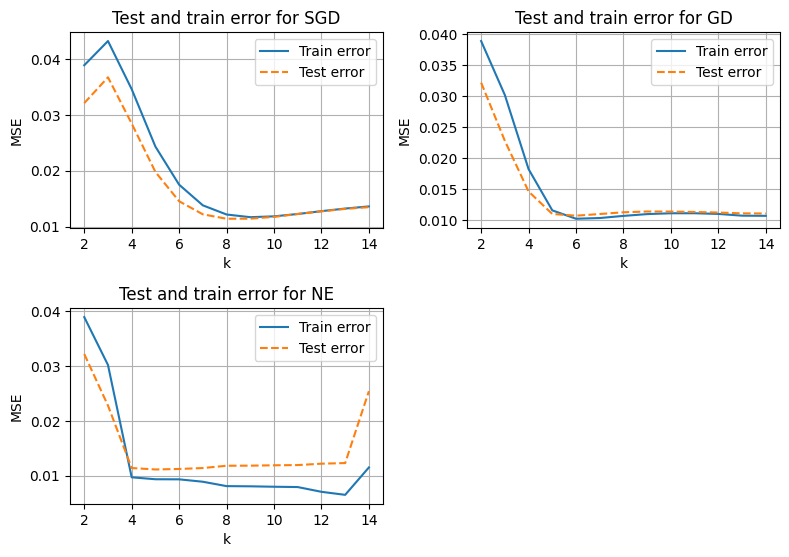

In [13]:
def plot_errs(loss, grad_loss, Dtrain, Dtest, Ks, alpha, size_batch, n_epochs):
    methods = ['SGD', 'GD', 'NE']
    errs_test = [[],[],[]]
    errs_train = [[],[],[]]

    for k in range(len(Ks)):
        theta0 = np.zeros((Ks[k],))
        theta_SGD = mle_SGD(loss, grad_loss, Dtrain, theta0, alpha, size_batch, n_epochs, Ks[k])
        theta_GD = mle_GD_backtracking(loss, grad_loss, Dtrain, theta0, Ks[k])
        theta_NE = mle_Normal_Eq(Dtrain[0], Dtrain[1], Ks[k])

        for j, theta in enumerate([theta_SGD, theta_GD, theta_NE]):
            predictions = model(Dtest[0], theta)
            errors = (predictions - Dtest[1]) ** 2
            mean_error = np.mean(errors)
            errs_test[j].append(mean_error)
            predictions = model(Dtrain[0], theta)
            errors = (predictions - Dtrain[1]) ** 2
            mean_error = np.mean(errors)
            errs_train[j].append(mean_error)
    plt.figure(figsize=(8,8))
    for i in range(3):
        plt.subplot(3, 2, i+1)
        plt.title(f'Test and train error for {methods[i]}')
        plt.plot(Ks, errs_train[i], label=f'Train error')
        plt.plot(Ks, errs_test[i], label=f'Test error', linestyle='--')
        plt.legend()
        plt.grid()
        plt.ylabel('MSE')
        plt.xlabel(r'k')
        plt.tight_layout()

plot_errs(mle_Obj, mle_grad, (Xtrain, Ytrain), (Xtest, Ytest), range(2,15), 0.01, 5, 200)

From the plot of the errors of the polynomial model trained by solving the Normal Equations the overfitting can be spotted, as the train error decreases while the test error starts increasing, suggesting that the model becomes to complex and starts to model the noise of the train data becoming unable to generalize on new data. This behavior is not present in SGD and GD.

## Maximum a Posteriori  Estimation (MAP)

In the last part of the homework I will consider the MAP formulation with the Gaussian assumption on the prior term $p(\theta)$, which means solving:
$$\theta_{MAP} = \argmin_{\theta \in \mathbb{R^K}}\frac{1}{2}\|\Phi(X)^T\theta - Y\|^2_2 + \frac{\lambda}{2}\|\theta\|^2_2,$$
where the matrix $\Phi(X)$ is defined as at the beginning of the homework and $K$ is the degree of the polynomial model.

The gradient of the loss is: 
$$\nabla \mathcal{L}(\theta) = \Phi(X)(\Phi(X)^T\theta - Y) + \lambda \theta,$$
where I denoted as $\mathcal{L}(\theta)$ the objective function of the optimization problem.

The new loss and its gradient are implemented in the following.

In [8]:
def map_Obj(lamb):
    def func(theta, Phi, y):
        return (np.linalg.norm((Phi.T@theta - y), 2)**2 / 2) + (lamb * 0.5 * np.linalg.norm(theta)**2)
    return func

def map_grad(lamb):
    def grad_func(theta, Phi, y):
        return ((Phi@Phi.T@theta) - (Phi@y) + lamb * theta)
    return grad_func

The three procedures used for optimizing the paramaters for the MAP estimation are defined below.

In [9]:
def map_Normal_Eq(X, Y, K, lamb):
    Phi = generate_matrix(X,K)
    L = np.linalg.cholesky(Phi@Phi.T + lamb * np.eye(K))
    z = np.linalg.solve(L,Phi@Y)
    theta = np.linalg.solve(L.T, z)
    return theta

def map_SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs, K):
    thetas, losses, grad_norms = SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs, K)
    return thetas[-1]

def map_GD_backtracking(loss, grad_loss, D, theta0, K, maxit=500):
    thetas, k, f_val, grad_norm = GD_backtracking(loss, grad_loss, D, theta0, K, maxit)
    return thetas[-1]

The following code plots for each used method the test and train data as well as the ploynomial defined by the found thetas for different values of the $\lambda$ parameter. The test error for the found parameters $\theta$ is also printed for each method.

Note that among the considered $\lambda$ values there is also $0$, which is exactly the same as considering the previously defined MLE. This was done in order to compare the found solution with MAP to the solution found with MLE. 

+----------+-------------------+-----------+-----------+
| Lambda   |   Normal Equation |       SGD |        GD |
+==========+===================+===========+===========+
| 0-MLE    |         0.0118174 | 0.0114115 | 0.011131  |
+----------+-------------------+-----------+-----------+
| 0.01     |         0.0110385 | 0.0118616 | 0.0111219 |
+----------+-------------------+-----------+-----------+
| 0.05     |         0.0111487 | 0.0151063 | 0.0111656 |
+----------+-------------------+-----------+-----------+
| 0.1      |         0.0113925 | 0.0207745 | 0.0114075 |
+----------+-------------------+-----------+-----------+
| 0.2      |         0.0123035 | 0.0322798 | 0.0123075 |
+----------+-------------------+-----------+-----------+


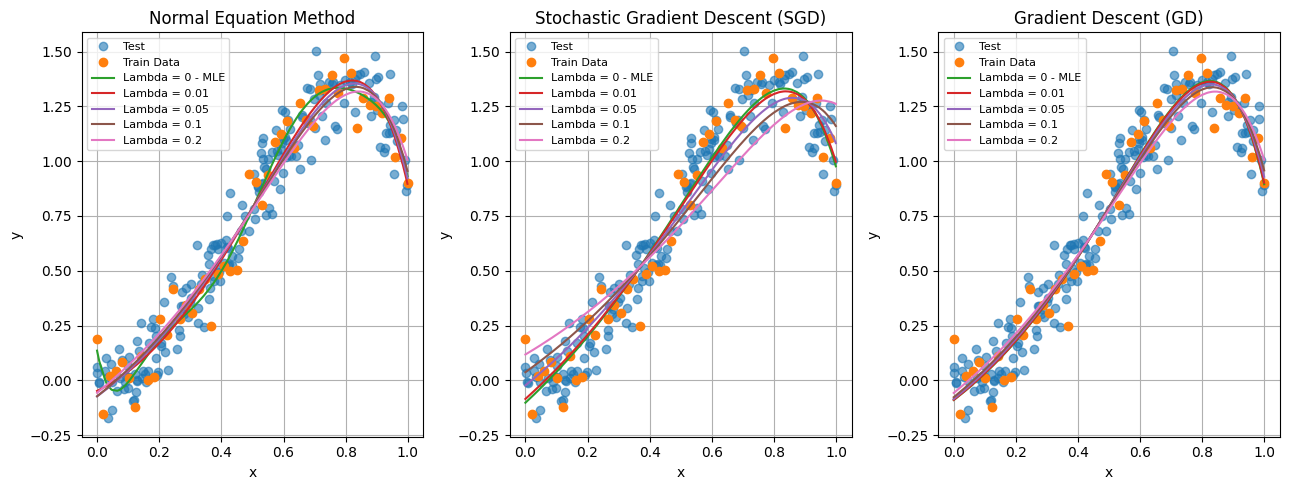

In [14]:
from tabulate import tabulate

Xtest = Xtest.flatten()
sorted_indices = np.argsort(Xtest)
Xtest_sorted = Xtest[sorted_indices]
Ytest_sorted = Ytest[sorted_indices]

lambdas = [0, 0.01, 0.05, 0.1, 0.2]

def compute_and_plot(method_name, train_func, subplot_index):
    plt.subplot(1, 3, subplot_index)
    plt.title(f"{method_name}")
    plt.plot(Xtest, Ytest, 'o', label='Test',alpha=0.6)
    plt.plot(Xtrain.flatten(), Ytrain, 'o', label='Train Data')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()

    perf = []
    for lamb in lambdas:
        theta = train_func(lamb)  
        predictions = model(Xtest, theta)
        errors = (predictions - Ytest) ** 2
        mean_error = np.mean(errors)
        perf.append(mean_error)

        # Plot predictions
        if lamb == 0:
            lamb = '0 - MLE'
        plt.plot(Xtest_sorted, model(Xtest_sorted, theta), label=f'Lambda = {lamb}')
    plt.legend(fontsize=8)
    return perf

plt.figure(figsize=(13, 5))

perf_NE = compute_and_plot("Normal Equation Method", lambda lamb: map_Normal_Eq(Xtrain, Ytrain, 8, lamb), subplot_index=1)

perf_SGD = compute_and_plot("Stochastic Gradient Descent (SGD)", lambda lamb: map_SGD(map_Obj(lamb), map_grad(lamb), (Xtrain, Ytrain), np.zeros(8), 0.01, 8, 200, 8), subplot_index=2)

perf_GD = compute_and_plot("Gradient Descent (GD)", lambda lamb: map_GD_backtracking(map_Obj(lamb), map_grad(lamb), (Xtrain, Ytrain), np.zeros(8), 8), subplot_index=3)

plt.tight_layout()

headers = ['Lambda', 'Normal Equation', 'SGD', 'GD']
table = [[('0-MLE' if lamb == 0 else lamb), perf_NE[i], perf_SGD[i], perf_GD[i]] for i, lamb in enumerate(lambdas)]
print(tabulate(table, headers=headers, tablefmt="grid"))

The positive effect of the regularization is mostly visible for the Normal Equation method as it was the method that was the most prone to overfit with the MLE. By adding the regularization term the found polynomial is much less _complex_ than the one found with MLE ($\lambda=0$) and it doesn't seem to overfit the plotted train data anymore. The addition of the regularization parameter $\lambda$, on the other hand, worsens the performance of the SGD, while for the GD it seems there are not great differences with the MLE found solution. For larger values of $\lambda$ the results were even worse for GD and SGD that suffered a lot from the regularization increase.

Below I plot the test and train error as a function of the model's complexity, i.e. the degree $K$. The plots are done for every method and for different values of $\lambda$. 

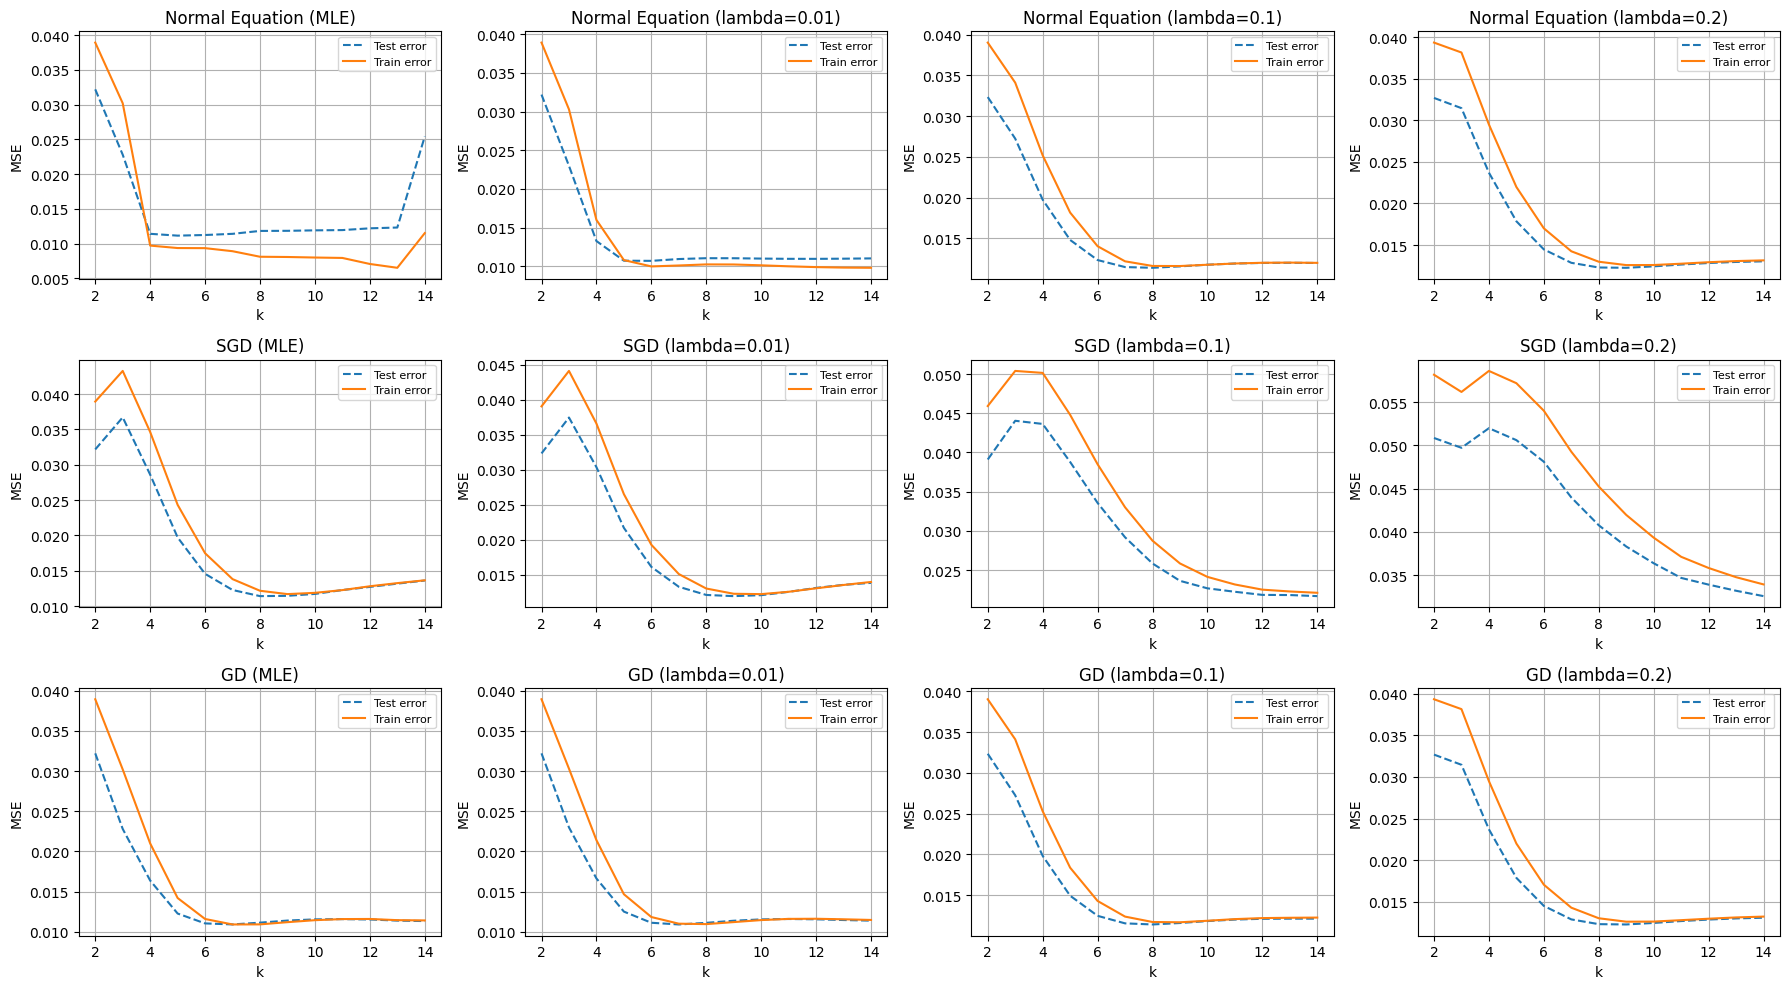

In [15]:
lambdas = [0, 0.01, 0.1, 0.2]
ks = range(2, 15)

plt.figure(figsize=(18, 10))

def compute_errors(train_f, Xtrain, Ytrain, Xtest, Ytest, lamb, ks):
    train_err, test_err = [], []
    for k in ks:
        theta = train_f(Xtrain, Ytrain, k, lamb)

        predictions_test = model(Xtest, theta)
        test_err.append(np.mean((predictions_test - Ytest) ** 2))

        predictions_train = model(Xtrain, theta)
        train_err.append(np.mean((predictions_train - Ytrain) ** 2))
    return train_err, test_err

methods = [
    {"name": "Normal Equation", "func": map_Normal_Eq},
    {"name": "SGD", "func": lambda X, Y, k, lamb: map_SGD(map_Obj(lamb), map_grad(lamb), (X, Y), np.zeros(k), 0.01, 5, 200, k)},
    {"name": "GD", "func": lambda X, Y, k, lamb: map_GD_backtracking(map_Obj(lamb), map_grad(lamb), (X, Y), np.zeros(k), k)},
]

for idx, method in enumerate(methods):
    for lamb_idx, lamb in enumerate(lambdas):
        plt.subplot(len(methods), len(lambdas), idx * len(lambdas) + lamb_idx + 1)
        train_err, test_err = compute_errors(method["func"], Xtrain, Ytrain, Xtest, Ytest, lamb, ks)
        plt.plot(ks, test_err, label="Test error", linestyle='--')
        plt.plot(ks, train_err, label="Train error")
        if lamb == 0:
            plt.title(f"{method['name']} (MLE)")
        else:
            plt.title(f"{method['name']} (lambda={lamb})")
        plt.xlabel(r"k")
        plt.ylabel("MSE")
        plt.grid()
        plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

These plots clearly visualize the idea of the regularization parameter and its benefits on the NE method where in fact the overfitting completely disappears. The behavior of the errors in the two other cases seems to be independent from these values of $\lambda$.

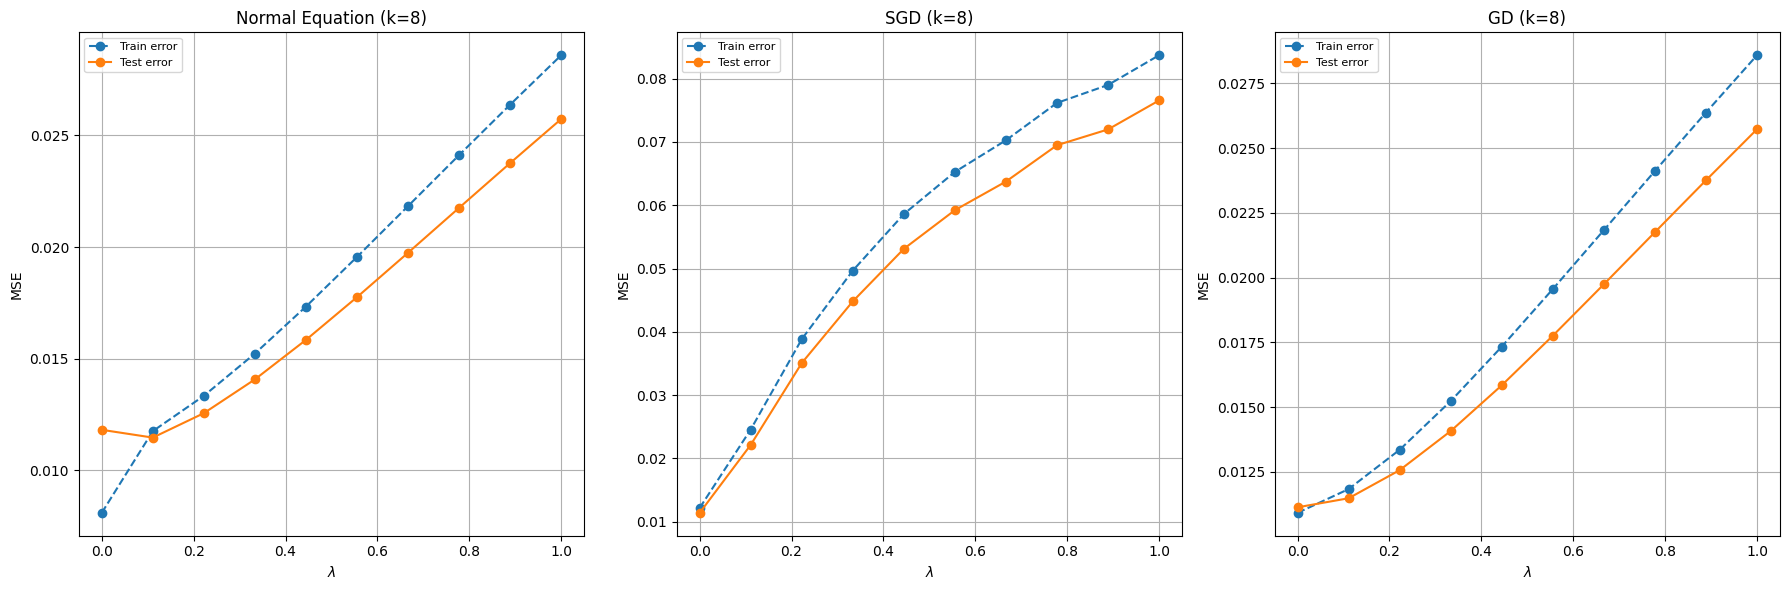

In [16]:
lambdas = np.linspace(0,1,10)
k = 8 

def compute_errors_k(train_f, Xtrain, Ytrain, Xtest, Ytest, lambdas, k):
    train_err, test_err = [], []
    for lamb in lambdas:
        theta = train_f(Xtrain, Ytrain, k, lamb)

        predictions_test = model(Xtest, theta)
        test_err.append(np.mean((predictions_test - Ytest) ** 2))

        predictions_train = model(Xtrain, theta)
        train_err.append(np.mean((predictions_train - Ytrain) ** 2))
    return train_err, test_err

methods = [
    {"name": "Normal Equation", "func": map_Normal_Eq},
    {"name": "SGD", "func": lambda X, Y, k, lamb: map_SGD(map_Obj(lamb), map_grad(lamb), (X, Y), np.zeros(k), 0.01, 8, 200, k)},
    {"name": "GD", "func": lambda X, Y, k, lamb: map_GD_backtracking(map_Obj(lamb), map_grad(lamb), (X, Y), np.zeros(k), k)},
]

plt.figure(figsize=(18, 6))
for idx, method in enumerate(methods):
    train_err, test_err = compute_errors_k(method["func"], Xtrain, Ytrain, Xtest, Ytest, lambdas, k)
    
    plt.subplot(1, 3, idx + 1)  
    plt.plot(lambdas, train_err, label="Train error", linestyle='--', marker='o')
    plt.plot(lambdas, test_err, label="Test error", linestyle='-', marker='o')
    
    plt.title(f"{method['name']} (k={k})")
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE")
    plt.grid()
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
